#Final: 4 Fourier Meets Neural Networks

## Yuchong Liu

<hr>

**Problem Statements:**
An approximation to a Fourier Series can be cast as a neural network where the input is a single number, which then fans out a number of neurons that output $\sin(2 \pi k x)$ and $\cos(2 \pi k x)$, for $k = 0 \dots n-1$. Those neurons are then multiplied by weights and summed together, which can be accomplished with a fully connected layer with $2n$ inputs and one output.  Graphically, this looks like the following:

<img src="https://raw.githubusercontent.com/klavins/EE502P/master/images/fourier-network.jpeg" width=60%>

This problem is mainly testing our ability of using pytorch and understanding of fourier series.

**Solution:**
According to the graph above, there are 2 steps for our solution. First, we need to get the list of sin and cos of x. Then a one-layer neural network should be used to train the weights of cos and sin, and bias should be zero.

In [0]:
import numpy as np
import sympy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

##a) Build the model

In this part, we are building the forward relation of the whole network. It's easy. For the first step, we generate $\bf{\cos}$ and $\bf{\sin}$ of number n from a single input x. Then we put the list of $\bf{\cos}$ and $\bf{\sin}$ together and send them into a linear layer.

The initial parameters should be randomly generated.

In [0]:
class Model(nn.Module):
    def __init__(self, N):
        super(Model, self).__init__()
        self.num = N
        self.fc1 = nn.Linear(2*N, 1)

    def forward(self, x):
        x = self.get_sin_cos_input(x)
        x = self.fc1(x)
        return x

    def get_sin_cos_input(self, x):
        cos = np.empty([self.num, len(x)])
        sin = np.empty([self.num, len(x)])
        # print('ret:', ret)
        for i in range(self.num):
            cos[i, :] = np.cos(2*i*np.pi*x)
            sin[i, :] = np.sin(2*i*np.pi*x)
        ret = np.vstack((cos, sin)).T
        return torch.tensor(ret, dtype=torch.float)


n = 10
model = Model(n)

init_weights = np.random.randn(2*n)
model.fc1.weight.data = torch.tensor([init_weights], dtype=torch.float)
model.fc1.bias.data = torch.tensor([0],dtype=torch.float)

## b) Test with square wave

In this part, we need to make some test data as a square wave evaluated on a random list of numbers between 0 and 1.

### 1)Make data

torch.Size([200, 1])


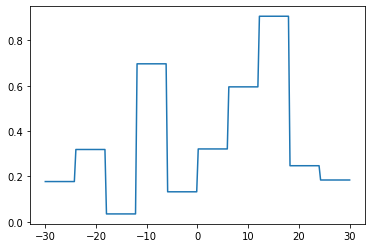

In [3]:
def make_data(SAMPLE_RATE=1000, STEPS=20):
    t = np.linspace(-30, 30, SAMPLE_RATE)
    y_val = np.random.random(STEPS)
    y_real = []
    for i in range(STEPS):
        y_real += [y_val[i]] * int(SAMPLE_RATE/STEPS)
    y_real = torch.tensor(y_real, dtype=torch.float).reshape(SAMPLE_RATE, 1)
    return t, y_real


t, y_real = make_data(200, 10)
print(y_real.shape)
plt.plot(t, y_real)

### 2) Test the model

The codes and results are shown below. The blue line is the ground truth of generated square wave function and the points are the estimation values of the model.

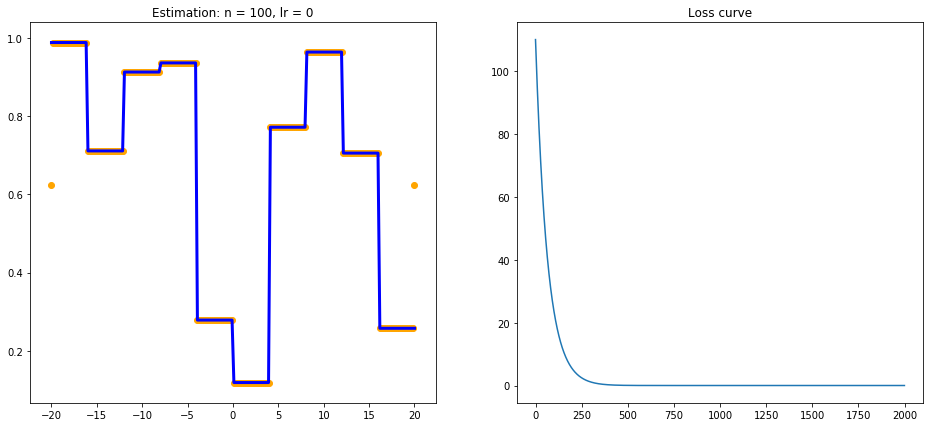

In [27]:
#@title
# set parameters
n = 100
TRAIN_TIMES = 2000
LEARNING_RATE = 0.01

# init model
model = Model(n)
init_weights = np.random.randn(2*n)
model.fc1.weight.data = torch.tensor([init_weights], dtype=torch.float)
model.fc1.bias.data = torch.tensor([0],dtype=torch.float)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = torch.nn.MSELoss()

# train the model
loss_rcd = []
for i in range(TRAIN_TIMES):
    y_estm = model(t)
    # print(y_estm.shape)
    loss = loss_func(y_estm, y_real)
    # print(loss)
    loss_rcd.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# plot the curve
y_estm = y_estm.detach().T.tolist()[0]
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(t, y_real.numpy(), c='blue', lw='3')
ax[0].scatter(t, y_estm, c='orange')
ax[0].title.set_text('Estimation: n = %d, lr = %d' % (n, LEARNING_RATE))
ax[1].plot(loss_rcd)
ax[1].title.set_text('Loss curve')

plt.show()

## c) Change N

When we change the number of n from 10 to 20 to 100, it shows a more and more accurate estimation of the function, which means within the same training times and the same learning rate, estimation with higher orders of fourier series has more accurate weights than others.

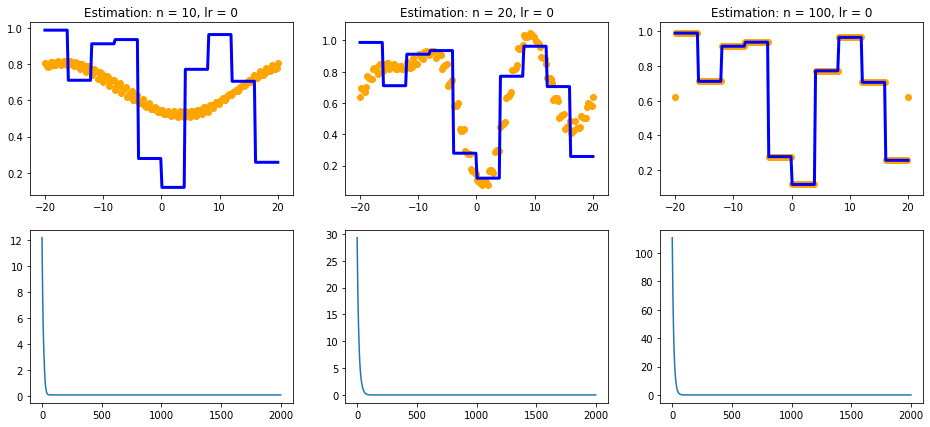

In [31]:
#@title
# change n
n = [10, 20, 100]
TRAIN_TIMES = 2000
LEARNING_RATE = 0.05

loss_rcd = [None]*len(n)
y_estm = [None]*len(n)
for i in range(len(n)):
    model = Model(n[i])
    init_weights = np.random.randn(2*n[i])
    model.fc1.weight.data = torch.tensor([init_weights], dtype=torch.float)
    model.fc1.bias.data = torch.tensor([0],dtype=torch.float)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_func = torch.nn.MSELoss()

    losses = []
    for j in range(TRAIN_TIMES):
        y_estm[i] = model(t)
        loss = loss_func(y_estm[i], y_real)
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_estm[i] = y_estm[i].detach().T.tolist()[0]
    loss_rcd[i] = losses

fig, ax = plt.subplots(2, 3, figsize=(16, 7))
ax[0, 0].plot(t, y_real.numpy(), c='blue', lw='3')
ax[0, 0].scatter(t, y_estm[0], c='orange')
ax[1, 0].plot(loss_rcd[0])
ax[0, 1].plot(t, y_real.numpy(), c='blue', lw='3')
ax[0, 1].scatter(t, y_estm[1], c='orange')
ax[1, 1].plot(loss_rcd[1])
ax[0, 2].plot(t, y_real.numpy(), c='blue', lw='3')
ax[0, 2].scatter(t, y_estm[2], c='orange')
ax[1, 2].plot(loss_rcd[2])

ax[0, 0].title.set_text('Estimation: n = %d, lr = %d' % (n[0], LEARNING_RATE))
ax[0, 1].title.set_text('Estimation: n = %d, lr = %d' % (n[1], LEARNING_RATE))
ax[0, 2].title.set_text('Estimation: n = %d, lr = %d' % (n[2], LEARNING_RATE))

plt.show()

## d) Try radial basis functions

Approximate the function by

$$
\hat f(x) = \sum_{i=1}^n r \left (x-\frac{i}{n} \right )
$$

where 

$$
r(x) = e^{-ax^2}
$$

and $a = 100$. 


**However**, different from cos and sin, the range of x of radial basis is much smaller, which is around 0 to 1. Becuase $r \left (x-\frac{i}{n} \right )$ is unexpectedly small when abs(x) is too large.

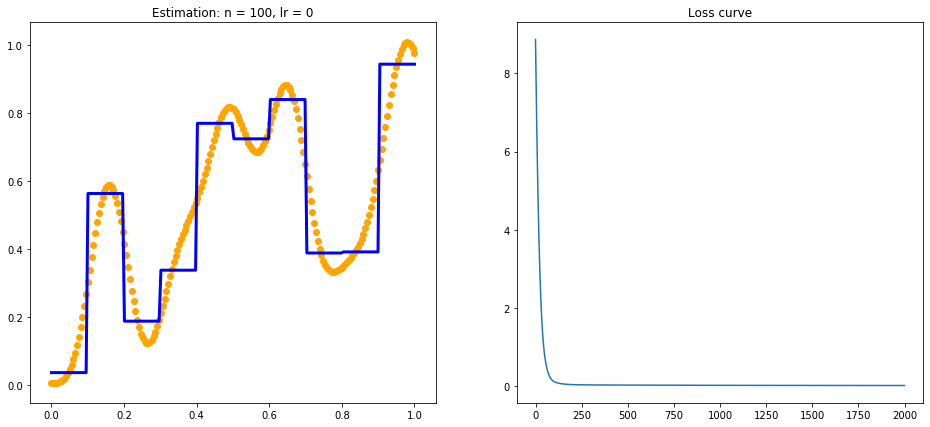

In [57]:
class Model_rbf(nn.Module):
    def __init__(self, N):
        super(Model_rbf, self).__init__()
        self.num = N
        self.fc1 = nn.Linear(self.num, 1)

    def forward(self, x):
        x = self.get_radial_basis(x)
        x = self.fc1(x)
        return x

    def get_radial_basis(self, x):
        rb = []
        for i in range(self.num):
            rb.append(np.exp(-100* np.square(x- i/self.num)))
        return torch.tensor(rb, dtype=torch.float).T

n = 100
TRAIN_TIMES = 2000
LEARNING_RATE = 0.005

# init model
model = Model_rbf(n)
init_weights = np.random.randn(n)  # 2n if fourier, n if radial basis
model.fc1.weight.data = torch.tensor([init_weights], dtype=torch.float)
model.fc1.bias.data = torch.tensor([0],dtype=torch.float)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = torch.nn.MSELoss()


t, y_real = make_data(200, 10)
loss_rcd = []
for i in range(TRAIN_TIMES):
    y_estm = model(t)
    # print(y_estm.shape)
    loss = loss_func(y_estm, y_real)
    # print(loss)
    loss_rcd.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


y_estm = y_estm.detach().T.tolist()[0]
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(t, y_real.numpy(), c='blue', lw='3')
ax[0].scatter(t, y_estm, c='orange')
ax[0].title.set_text('Estimation: n = %d, lr = %d' % (n, LEARNING_RATE))
ax[1].plot(loss_rcd)
ax[1].title.set_text('Loss curve')

plt.show()

# Appendix: all codes

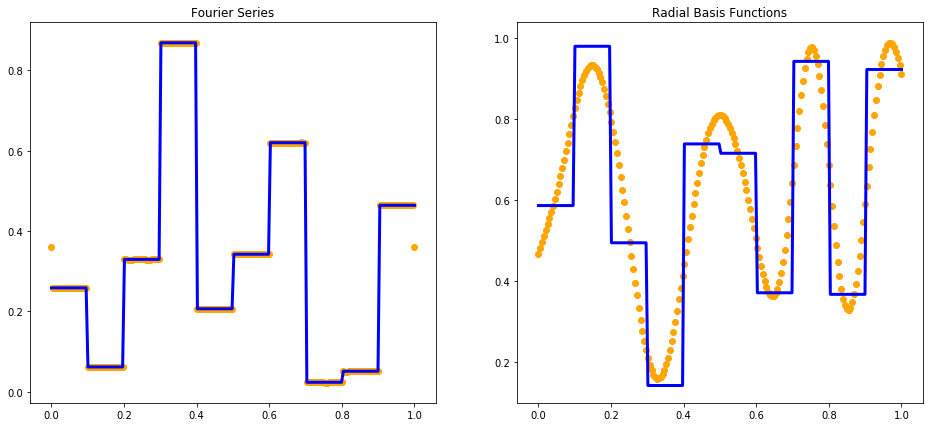

In [60]:
import numpy as np
import sympy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


class Model_fourier(nn.Module):
    def __init__(self, N):
        super(Model_fourier, self).__init__()
        self.num = N
        self.fc1 = nn.Linear(2*N, 1)

    def forward(self, x):
        x = self.get_sin_cos_input(x)
        x = self.fc1(x)
        return x

    def get_sin_cos_input(self, x):
        cos = np.empty([self.num, len(x)])
        sin = np.empty([self.num, len(x)])
        # print('ret:', ret)
        for i in range(self.num):
            cos[i, :] = np.cos(2*i*np.pi*x)
            sin[i, :] = np.sin(2*i*np.pi*x)
        ret = np.vstack((cos, sin)).T
        return torch.tensor(ret, dtype=torch.float)

    def get_radial_basis(self, x):
        rb = []
        for i in range(self.num):
            rb.append(np.exp(-100* np.square(x- i/self.num)))
        return torch.tensor(rb, dtype=torch.float).T


class Model_rbf(nn.Module):
    def __init__(self, N):
        super(Model_rbf, self).__init__()
        self.num = N
        self.fc1 = nn.Linear(self.num, 1)

    def forward(self, x):
        x = self.get_radial_basis(x)
        x = self.fc1(x)
        return x

    def get_radial_basis(self, x):
        rb = []
        for i in range(self.num):
            rb.append(np.exp(-100* np.square(x- i/self.num)))
        return torch.tensor(rb, dtype=torch.float).T


def make_data(SAMPLE_RATE=1000, STEPS=20, xlim=[0, 1]):
    t = np.linspace(xlim[0], xlim[1], SAMPLE_RATE)  # any if fourier, (0,1) if radial basis
    y_val = np.random.random(STEPS)
    y_real = []
    for i in range(STEPS):
        y_real += [y_val[i]] * int(SAMPLE_RATE/STEPS)
    y_real = torch.tensor(y_real, dtype=torch.float).reshape(SAMPLE_RATE, 1)
    return t, y_real


def fourier_estimation():
    n = 100
    TRAIN_TIMES = 2000
    LEARNING_RATE = 0.005

    model = Model_fourier(n)
    init_weights = np.random.randn(2*n)  # 2n if fourier, n if radial basis
    model.fc1.weight.data = torch.tensor([init_weights], dtype=torch.float)
    model.fc1.bias.data = torch.tensor([0],dtype=torch.float)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_func = torch.nn.MSELoss()

    t, y_real = make_data(200, 10, xlim=[-30, 30])  # xlim is important
    loss_rcd = []
    for i in range(TRAIN_TIMES):
        y_estm = model(t)
        # print(y_estm.shape)
        loss = loss_func(y_estm, y_real)
        # print(loss)
        loss_rcd.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    y_estm = y_estm.detach().T.tolist()[0]
    return y_real, y_estm


def rbf_estimation():
    n = 100
    TRAIN_TIMES = 2000
    LEARNING_RATE = 0.005

    model = Model_rbf(n)
    init_weights = np.random.randn(n)  # 2n if fourier, n if radial basis
    model.fc1.weight.data = torch.tensor([init_weights], dtype=torch.float)
    model.fc1.bias.data = torch.tensor([0],dtype=torch.float)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_func = torch.nn.MSELoss()

    t, y_real = make_data(200, 10, xlim=[0, 1])  # xlim is important
    loss_rcd = []
    for i in range(TRAIN_TIMES):
        y_estm = model(t)
        loss = loss_func(y_estm, y_real)
        loss_rcd.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    y_estm = y_estm.detach().T.tolist()[0]
    return y_real, y_estm

fourier_real, fourier_estm = fourier_estimation()
rbf_real, rbf_estm = rbf_estimation()

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(t, fourier_real.numpy(), c='blue', lw='3')
ax[0].scatter(t, fourier_estm, c='orange')
ax[0].title.set_text('Fourier Series')
ax[1].plot(t, rbf_real.numpy(), c='blue', lw='3')
ax[1].scatter(t, rbf_estm, c='orange')
ax[1].title.set_text('Radial Basis Functions')
plt.show()

